# Baysian Two-way Fixed Effects

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [3]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df

island_ids  years region_codes  prefecture_codes  populations  \
0             67   1970        32202                32          NaN   
1             67   1975        32202                32          NaN   
2             67   1980        32202                32          NaN   
3             67   1985        32202                32          NaN   
4             67   1990        32202                32          NaN   
...          ...    ...          ...               ...          ...   
1895         226   2000        39424                39        398.0   
1896         226   2005        39424                39        365.0   
1897         226   2010        39424                39        343.0   
1898         226   2015        39424                39        284.0   
1899         226   2020        39424                39        225.0   

      treatment_group  treatment_group_mainland  year_bridges_opened  \
0                   1                         1                 1999   
1                   1                         1                 1999   
2                   1                         1                 1999   
3                   1                         1                 1999   
4                   1                         1                 1999   
...               ...                       ...                  ...   
1895                1                         1                 1957   
1896                1                         1                 1957   
1897                1                         1                 1957   
1898                1                         1                 1957   
1899                1                         1                 1957   

      after_treated  year_connect_mainland  ...        income  area_km2  \
0                 0                   1999  ...           NaN      0.28   
1                 0                   1999  ...           NaN      0.28   
2                 0                   1999  ...           NaN      0.28   
3                 0                   1999  ...  4.243674e+07      0.28   
4                 0                   1999  ...  4.786833e+07      0.28   
...             ...                    ...  ...           ...       ...   
1895              1                   1957  ...  5.113370e+02      0.56   
1896              1                   1957  ...  4.533435e+02      0.56   
1897              1                   1957  ...  3.903833e+02      0.56   
1898              1                   1957  ...  4.064721e+02      0.56   
1899              1                   1957  ...  3.758701e+02      0.56   

      distance_m  elementary_school  junior_high_school  high_school  \
0          615.0                NaN                 NaN          NaN   
1          615.0                NaN                 NaN          NaN   
2          615.0                NaN                 NaN          NaN   
3          615.0                NaN                 NaN          NaN   
4          615.0                NaN                 NaN          NaN   
...          ...                ...                 ...          ...   
1895       110.0                NaN                 NaN          NaN   
1896       110.0                NaN                 NaN          NaN   
1897       110.0                NaN                 NaN          NaN   
1898       110.0                NaN                 NaN          NaN   
1899       110.0                NaN                 NaN          NaN   

      hospital  population_change_rate  control_group  time_since_intervention  
0          NaN                     NaN              0                      -29  
1          NaN                     NaN              0                      -24  
2          NaN                     NaN              0                      -19  
3          NaN                     NaN              0                      -14  
4          NaN                     NaN              0                       -9  
...        ...                     .

## TWFE

$$
Y_{it} = \alpha_i + \lambda_t + \delta T_{it} + \epsilon_{it}
$$

$$
Y_{it} = intercept + \delta T_{it} + \tau \text{year}_{it} + \text{islands}_i + \text{years}_t + \epsilon_{it}
$$

## 正規分布

### ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


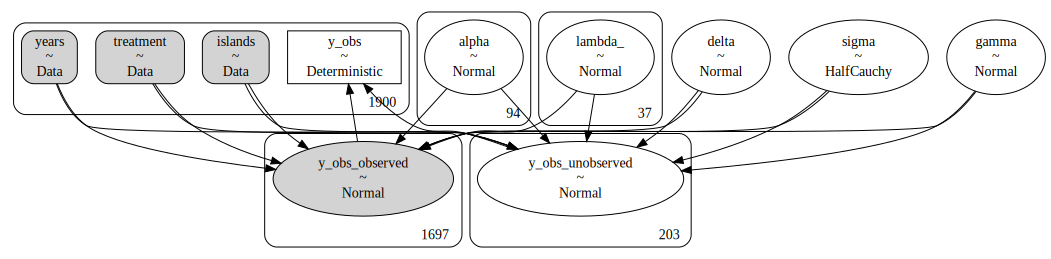

In [ ]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

with pm.Model() as twfe:
    # data
    islands = pm.Data('islands', df['island_ids'])
    years = pm.Data('years', df['years'])
    treatment = pm.Data('treatment', df['after_treated'])

    # priors
    alpha = pm.Normal('alpha', mu=0, sigma=100, shape=len(df['island_ids'].unique()))
    lambda_ = pm.Normal('lambda_', mu=0, sigma=100, shape=len(df['years'].unique()))
    delta = pm.Normal('delta', mu=0, sigma=100)
    sigma = pm.HalfCauchy('sigma', beta=100)

    # expectation
    mu = alpha[islands] + lambda_[years] + delta * treatment

    # likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(twfe)

In [5]:
with twfe:
    trace_twfe = pm.sample(
        draws=2000,
        tune=2000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

arviz - WARNING - Array contains NaN-value.
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
az.summary(trace_twfe, hdi_prob=.95, var_names=['delta', 'sigma'])

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
delta    0.211   0.329    -0.117       0.54      0.232    0.196       2.0   
sigma  133.790  86.331    47.470     220.11     60.923   51.585       2.0   

       ess_tail       r_hat  
delta       2.0  4876400.29  
sigma       2.0  4876400.29

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'lambda_'}>,
        <Axes: title={'center': 'lambda_'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'y_obs_unobserved'}>,
        <Axes: title={'center': 'y_obs_unobserved'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'y_obs'}>,
        <Axes: title={'center': 'y_obs'}>]], dtype=object)

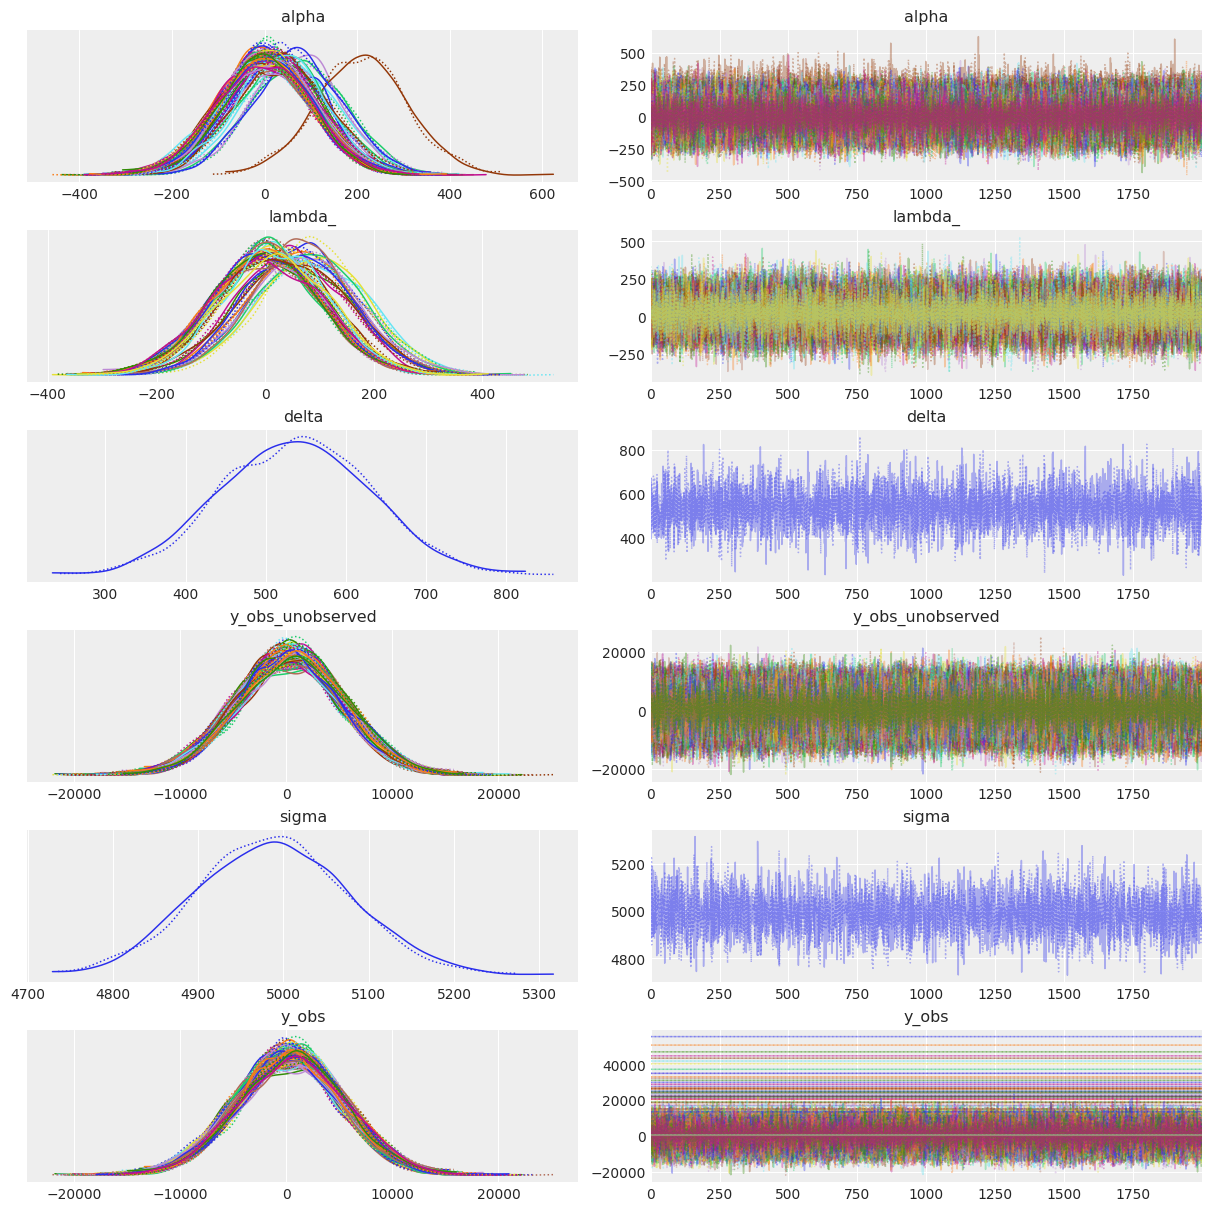

In [14]:
az.plot_trace(trace_twfe);

In [16]:
posterior_samples = trace_twfe.posterior

delta_samples = posterior_samples['delta']

# 0以上のサンプルの割合を計算
prob_delta_positive = np.mean(delta_samples > 0)

print(f"Pr(intercept > 0) = {prob_delta_positive:.4f}")

Pr(intercept > 0) = 1.0000


In [15]:
with twfe:
    pm.compute_log_likelihood(trace_twfe)

Output()

In [5]:
az.waic(trace_twfe)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -16870.76   144.00
p_waic       25.35        -

There has been a warning during the calculation. Please check the results.

### 階層ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


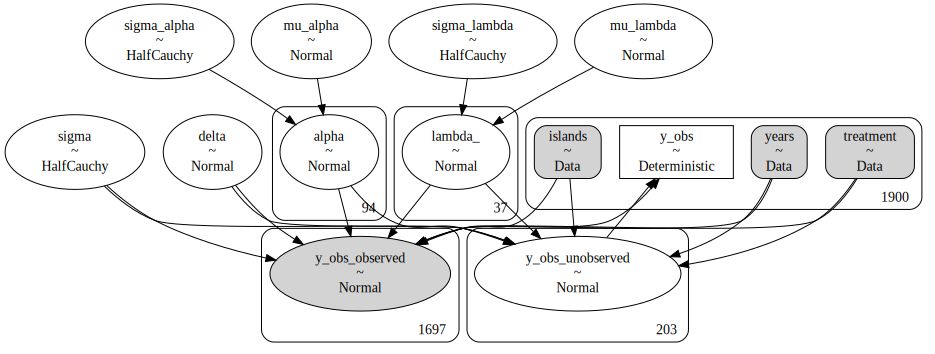

In [38]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])


with pm.Model() as twfe_h:
    # data
    islands = pm.Data('islands', df['island_ids'])
    years = pm.Data('years', df['years'])
    treatment = pm.Data('treatment', df['after_treated'])

    # priors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=100)
    sigma_alpha = pm.HalfCauchy('sigma_alpha', beta=100)
    mu_lambda = pm.Normal('mu_lambda', mu=0, sigma=100)
    sigma_lambda = pm.HalfCauchy('sigma_lambda', beta=100)
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=len(df['island_ids'].unique()))
    lambda_ = pm.Normal('lambda_', mu=mu_lambda, sigma=sigma_lambda, shape=len(df['years'].unique()))
    delta = pm.Normal('delta', mu=0, sigma=100)
    sigma = pm.HalfCauchy('sigma', beta=100)

    # expectation
    mu = alpha[islands] + lambda_[years] + delta * treatment

    # likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(twfe_h)

In [18]:
with twfe_h:
    trace_twfe_h = pm.sample(
        draws=2000,
        tune=2000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [19]:
az.summary(trace_twfe_h, hdi_prob=.95, var_names=['delta', 'sigma'])

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
delta    44.003  80.434  -107.099    208.464      1.167    1.071    4739.0   
sigma  1034.103  18.643   995.908   1069.764      0.347    0.246    2864.0   

       ess_tail  r_hat  
delta    3398.0    1.0  
sigma    2524.0    1.0

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


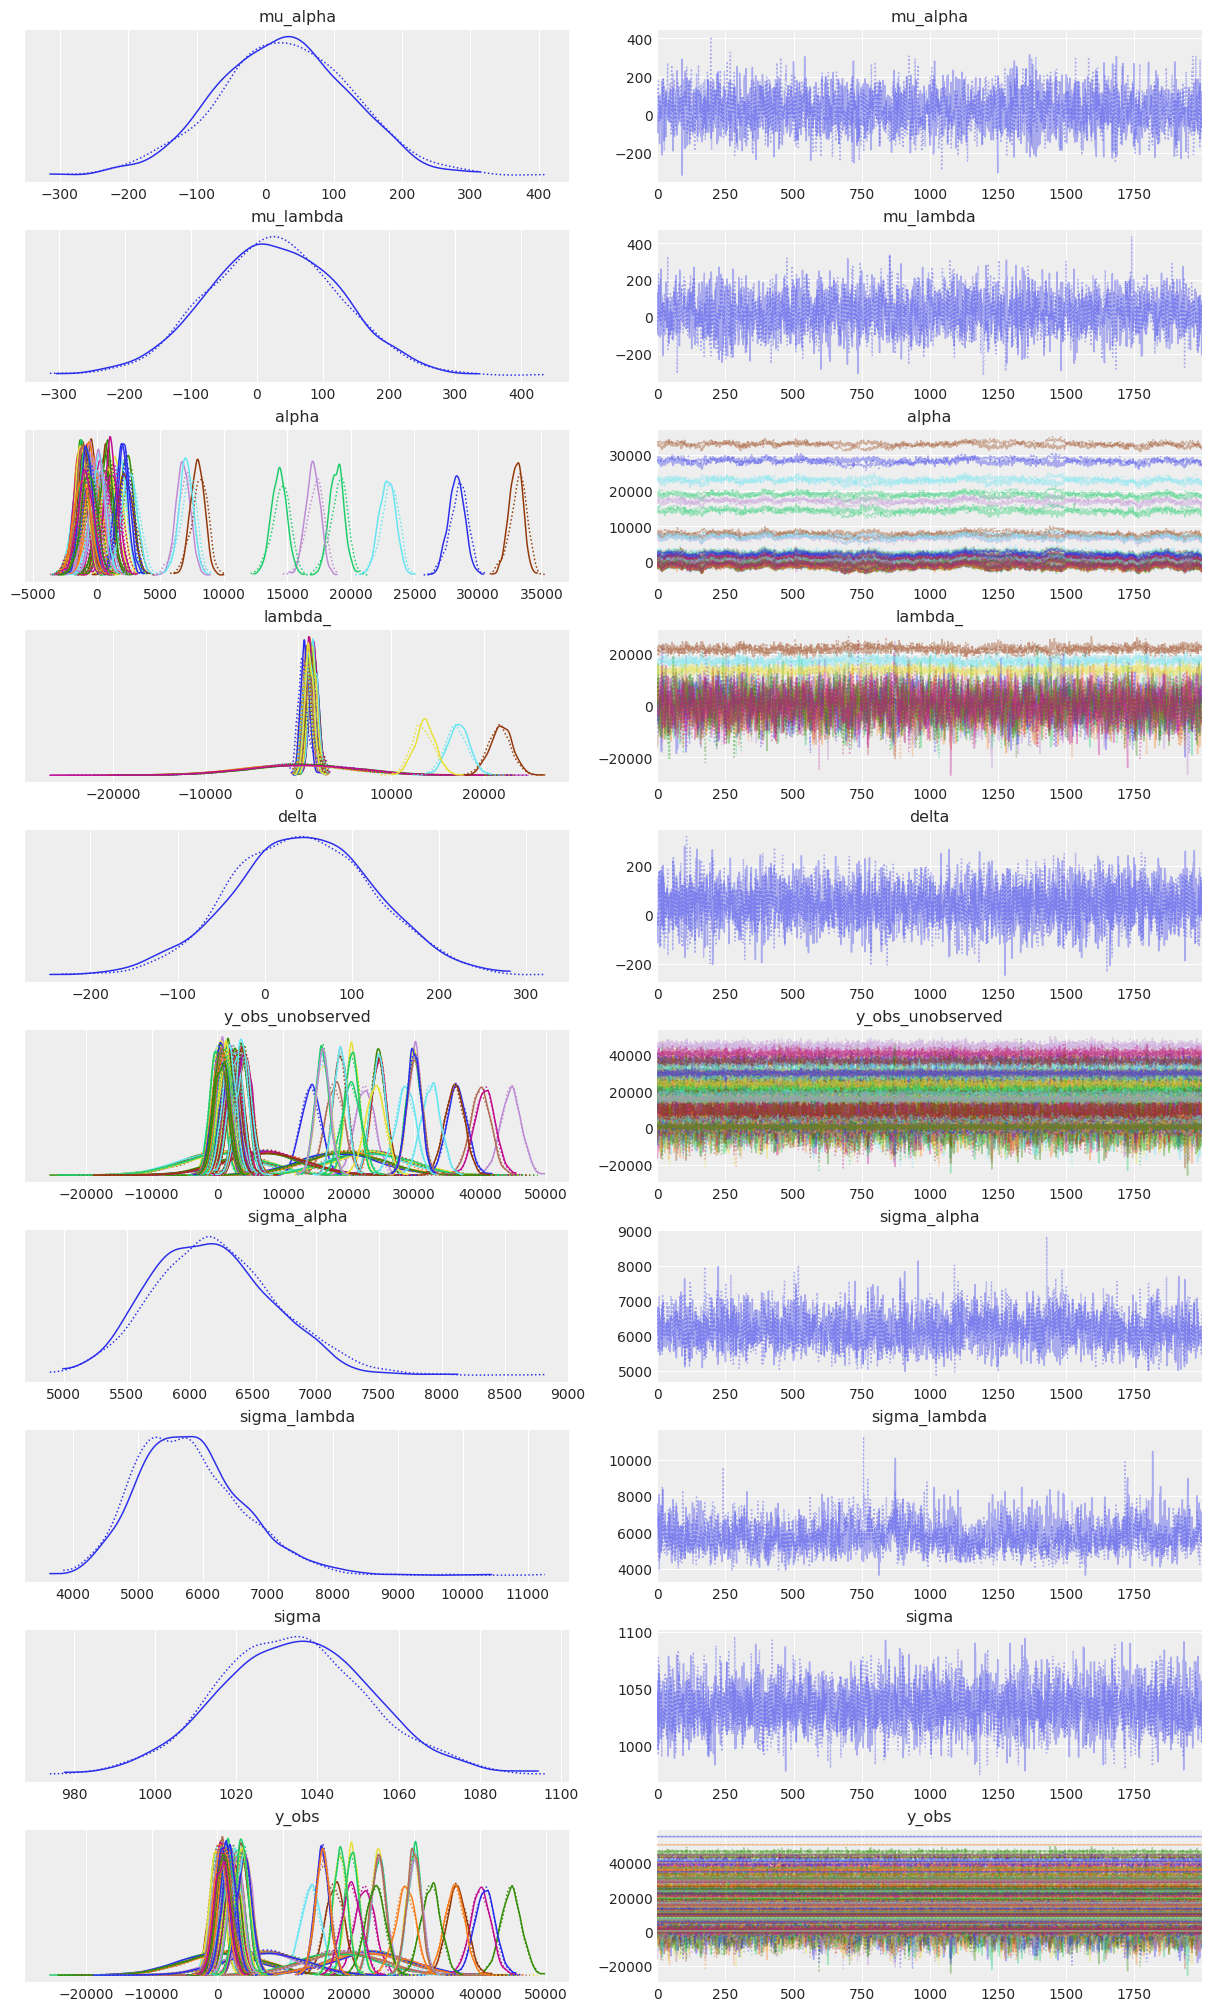

In [20]:
az.plot_trace(trace_twfe_h);

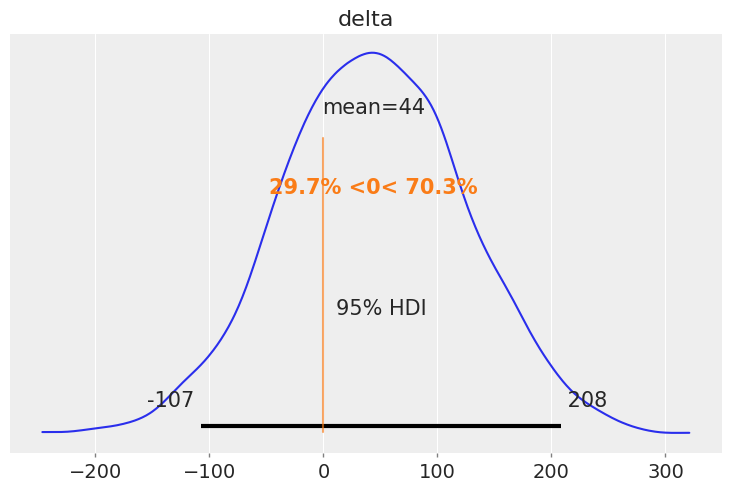

In [41]:
az.plot_posterior(trace_twfe_h, var_names=['delta'], ref_val=0, hdi_prob=.95);

In [24]:
posterior_samples = trace_twfe_h.posterior

delta_samples = posterior_samples['delta']

# 0以上のサンプルの割合を計算
prob_delta_positive = np.mean(delta_samples > 0)

print(f"Pr(intercept > 0) = {prob_delta_positive:.4f}")

Pr(intercept > 0) = 0.7030


In [22]:
with twfe_h:
    pm.compute_log_likelihood(trace_twfe_h)

Output()

In [6]:
az.waic(trace_twfe_h)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -14313.66   162.60
p_waic      219.02        -

There has been a warning during the calculation. Please check the results.

## Studet't分布

自由度パラメータ: $\nu = 3$

### ベイズモデル

In [19]:
unique_island_ids

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93],
      dtype='int64')

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


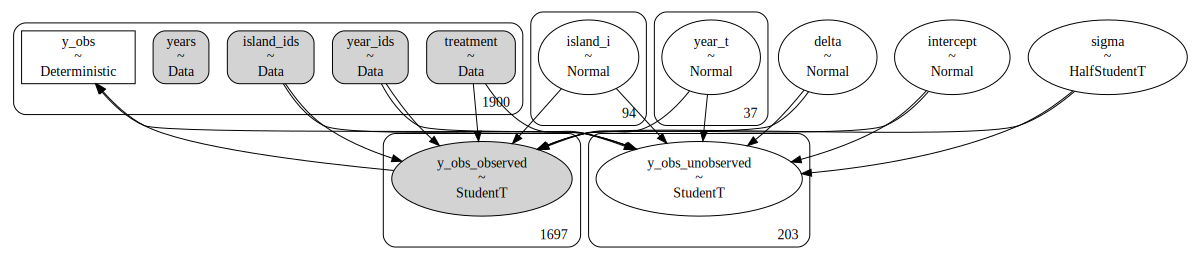

In [37]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
year_ids, unique_year_ids = pd.factorize(df['years'])


with pm.Model() as twfe_student_t:
    # data
    island_ids = pm.Data('island_ids', island_ids)
    year_ids = pm.Data('year_ids', year_ids)
    years = pm.Data('years', df['years'])
    treatment = pm.Data('treatment', df['after_treated'])

    # priors
    # random effects
    island_i = pm.Normal('island_i', mu=0, sigma=100, shape=len(unique_island_ids))
    year_t = pm.Normal('year_t', mu=0, sigma=100, shape=len(unique_year_ids))

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=100)
    delta = pm.Normal('delta', mu=0, sigma=100)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)

    # expectation
    mu = intercept + delta * treatment + island_i[island_ids] + year_t[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(twfe_student_t)

In [38]:
with twfe_student_t:
    trace_twfe_student_t = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [39]:
az.summary(trace_twfe_student_t, hdi_prob=.95, var_names=['intercept', 'delta', 'sigma'])

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  347.958  22.786   303.290    389.804      1.860    1.318     151.0   
delta       46.769  19.628     8.250     85.657      1.113    0.854     326.0   
sigma      118.948   6.079   107.636    130.861      0.255    0.181     571.0   

           ess_tail  r_hat  
intercept     300.0   1.01  
delta         307.0   1.01  
sigma         874.0   1.00

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


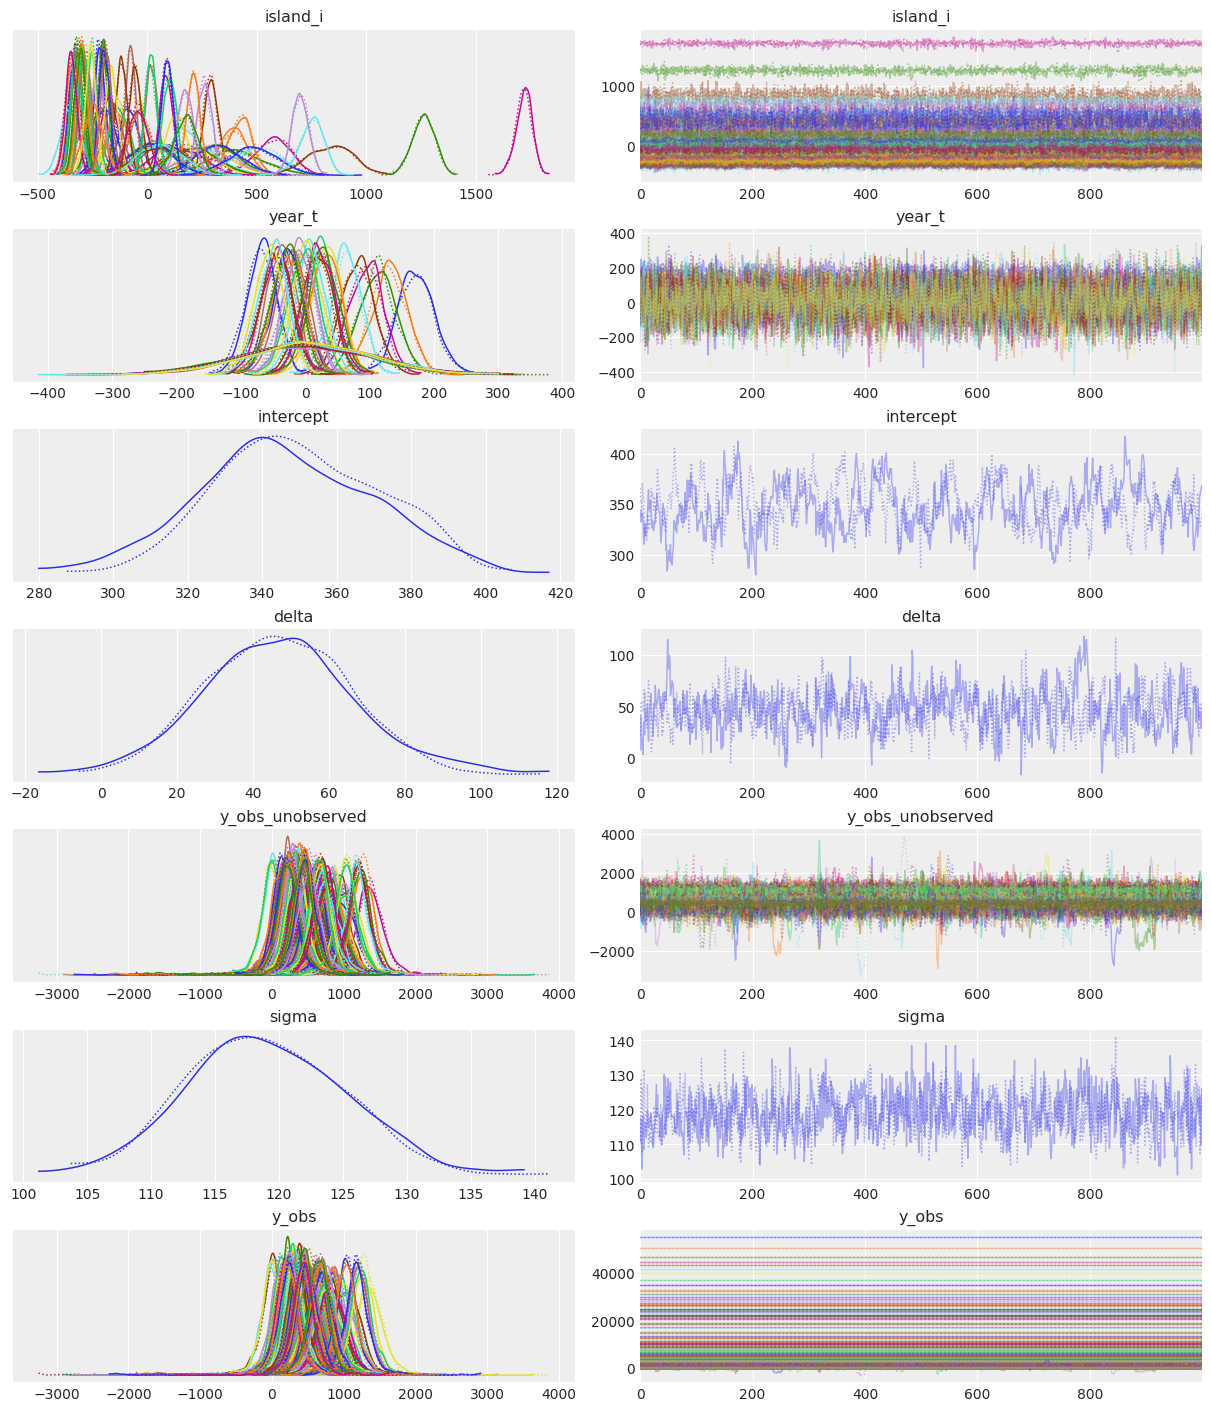

In [40]:
az.plot_trace(trace_twfe_student_t);

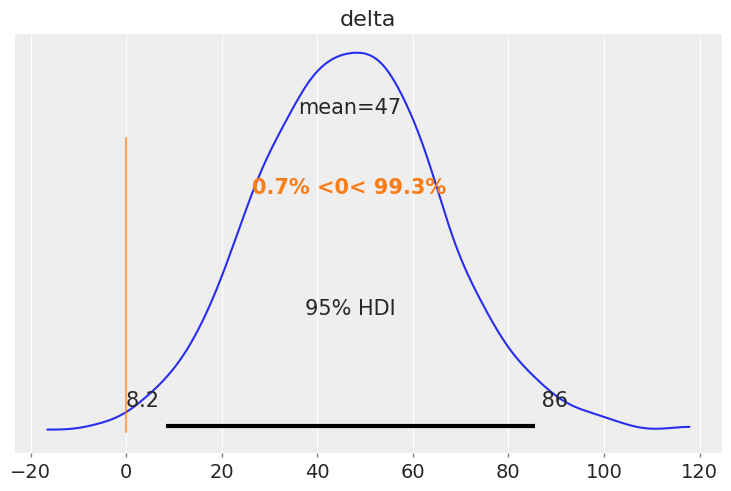

In [41]:
az.plot_posterior(trace_twfe_student_t, var_names=['delta'], ref_val=0, hdi_prob=.95);

In [42]:
with twfe_student_t:
    pm.compute_log_likelihood(trace_twfe_student_t)

Output()

In [43]:
az.waic(trace_twfe_student_t)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -13373.53   183.69
p_waic       78.10        -

There has been a warning during the calculation. Please check the results.

### 階層ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


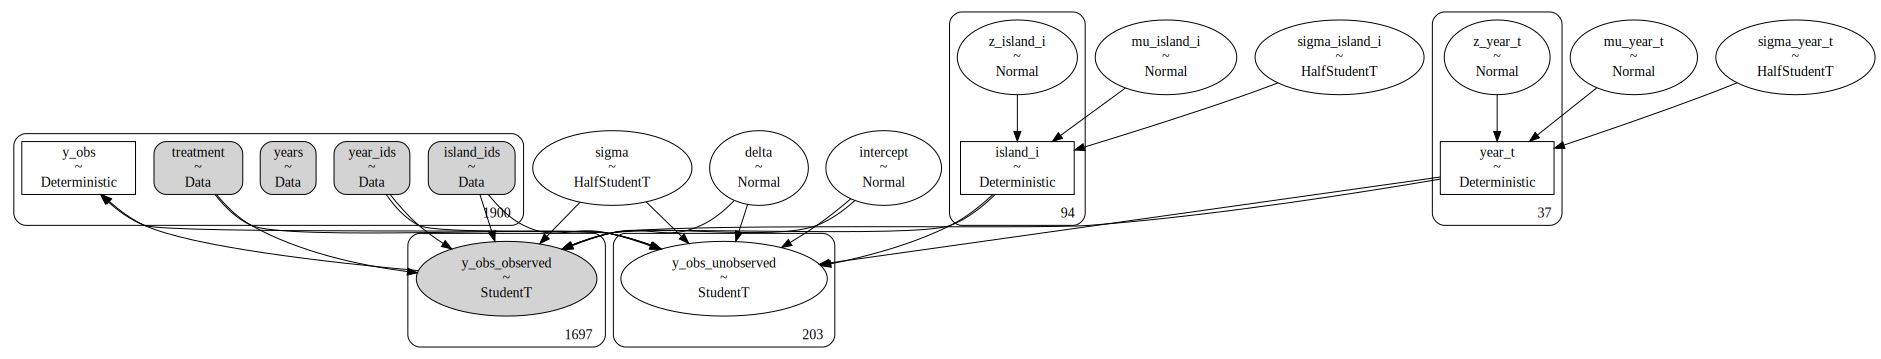

In [5]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['year_ids'], unique_year_ids = pd.factorize(df['years'])


with pm.Model() as twfe_h_student_t:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'])
    year_ids = pm.Data('year_ids', df['year_ids'])
    years = pm.Data('years', df['years'])
    treatment = pm.Data('treatment', df['after_treated'])

    # priors
    # random effects
    mu_island_i = pm.Normal('mu_island_i', mu=0, sigma=100)
    sigma_island_i = pm.HalfStudentT('sigma_island_i', nu=3, sigma=100)
    z_island_i = pm.Normal('z_island_i', mu=0, sigma=1, shape=len(unique_island_ids))
    island_i = pm.Deterministic('island_i', mu_island_i + sigma_island_i * z_island_i)

    mu_year_t = pm.Normal('mu_year_t', mu=0, sigma=100)
    sigma_year_t = pm.HalfStudentT('sigma_year_t', nu=3, sigma=100)
    z_year_t = pm.Normal('z_year_t', mu=0, sigma=1, shape=len(unique_year_ids))
    year_t = pm.Deterministic('year_t', mu_year_t + sigma_year_t * z_year_t)

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=100)
    delta = pm.Normal('delta', mu=0, sigma=100)

    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)

    # expectation
    mu = intercept + delta * treatment + island_i[island_ids] + year_t[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(twfe_h_student_t)

In [6]:
with twfe_h_student_t:
    trace_twfe_h_student_t = pm.sample(
        draws=2000,
        tune=2000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [8]:
az.summary(trace_twfe_h_student_t, hdi_prob=.95, var_names=['intercept', 'delta', 'sigma'])

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept   53.816  97.151  -134.114    243.087      5.859    4.147     275.0   
delta     -178.774  22.465  -223.046   -136.112      0.489    0.347    2119.0   
sigma       69.784   2.404    65.104     74.450      0.047    0.033    2602.0   

           ess_tail  r_hat  
intercept     722.0    1.0  
delta        2750.0    1.0  
sigma        2723.0    1.0

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


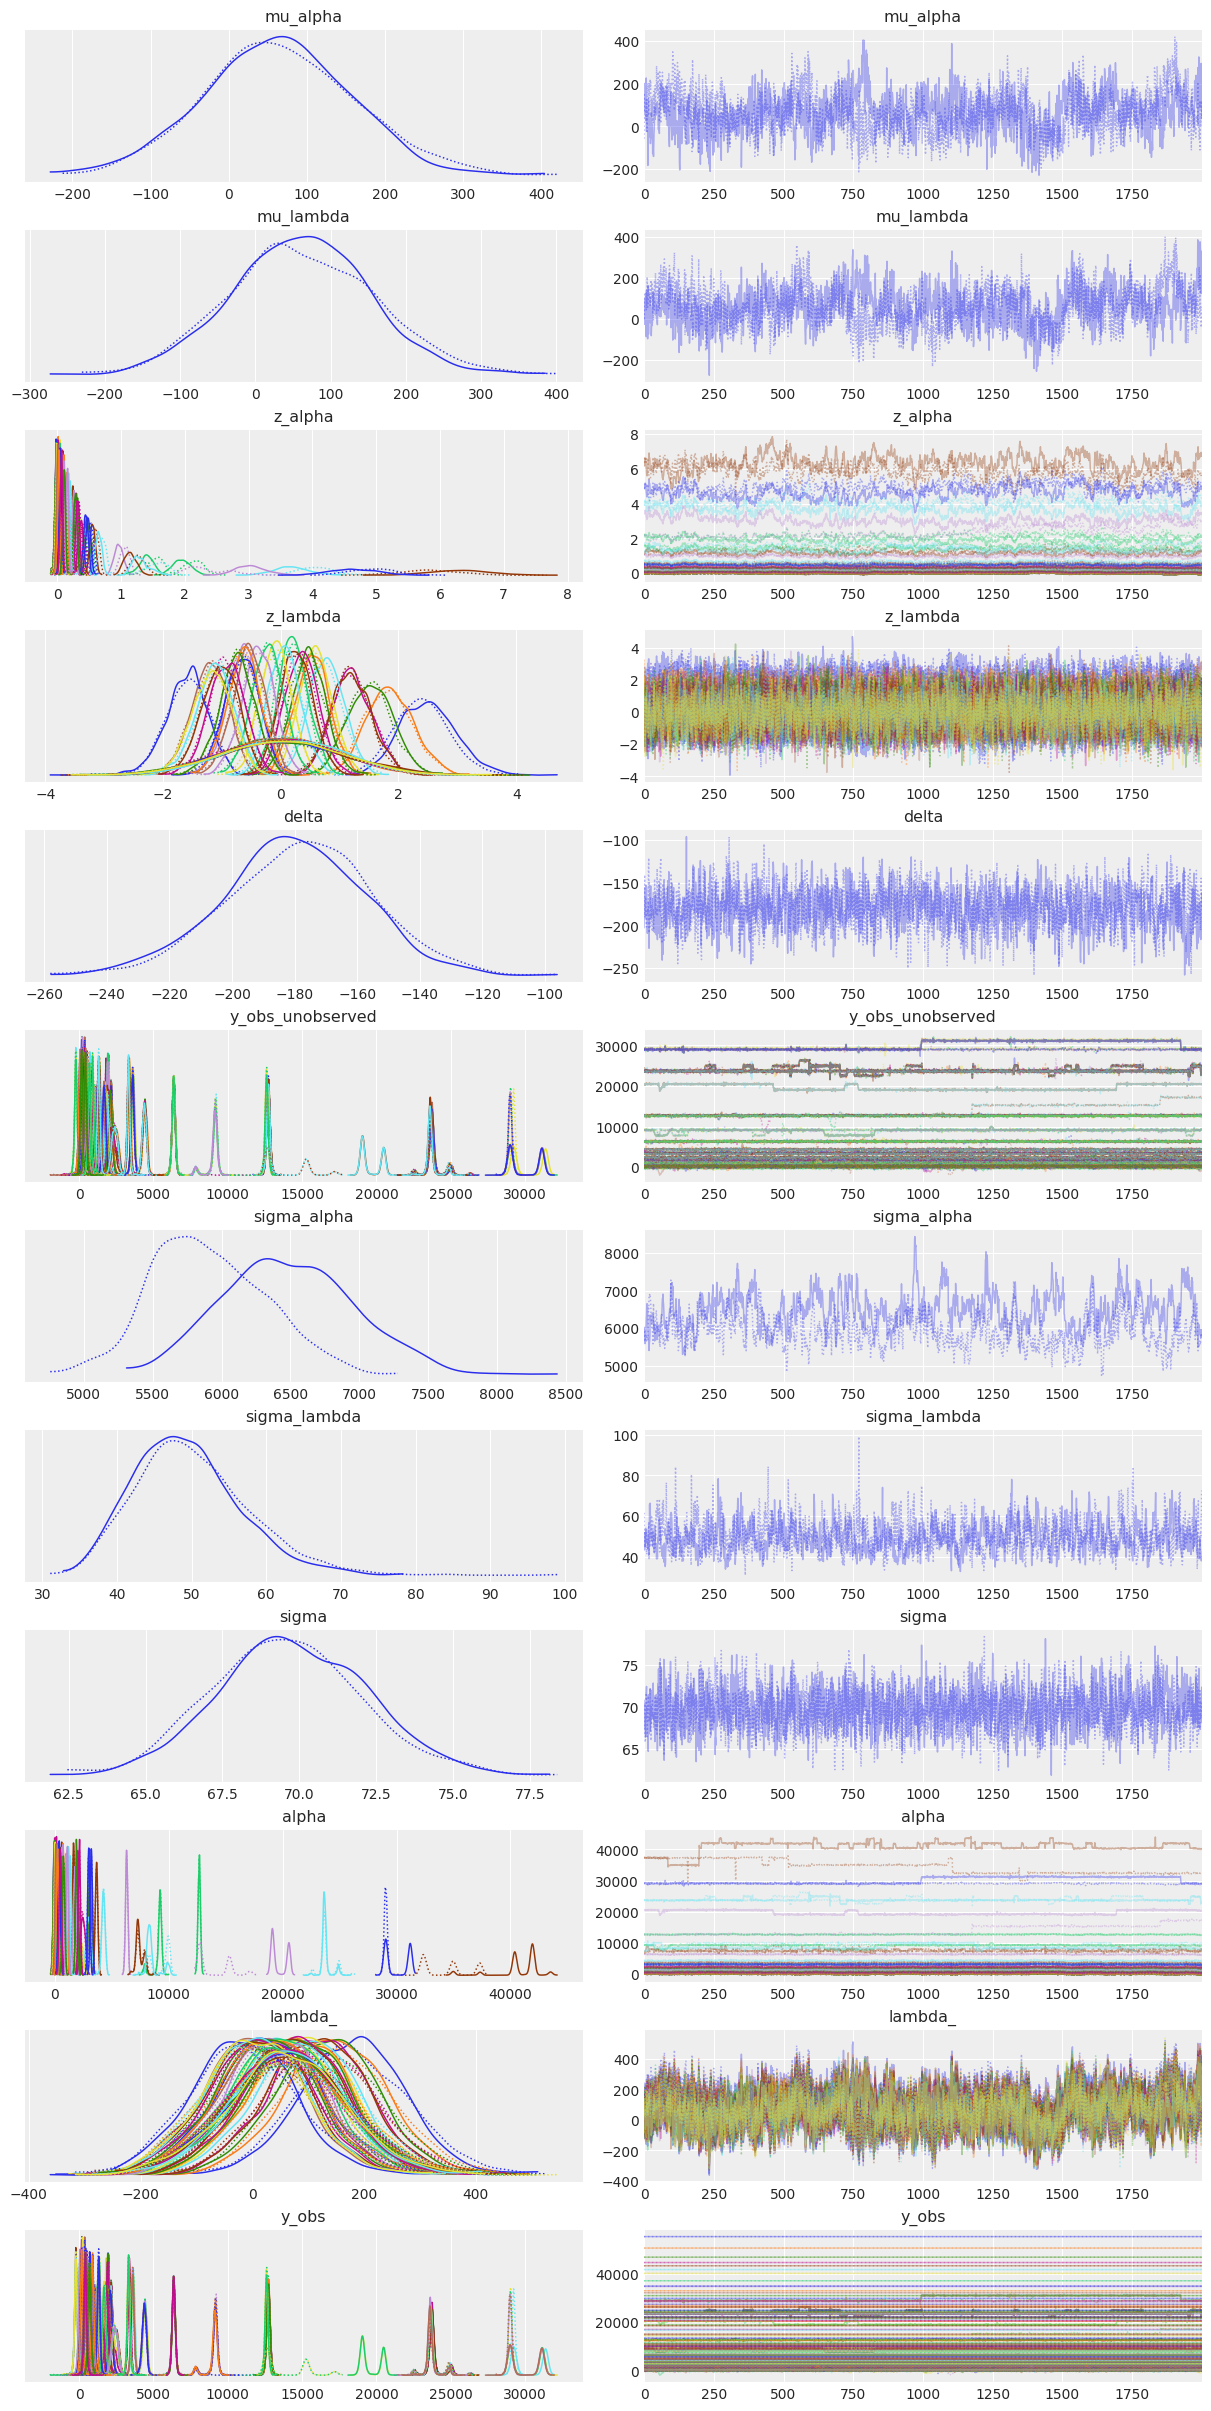

In [53]:
az.plot_trace(trace_twfe_h_student_t);

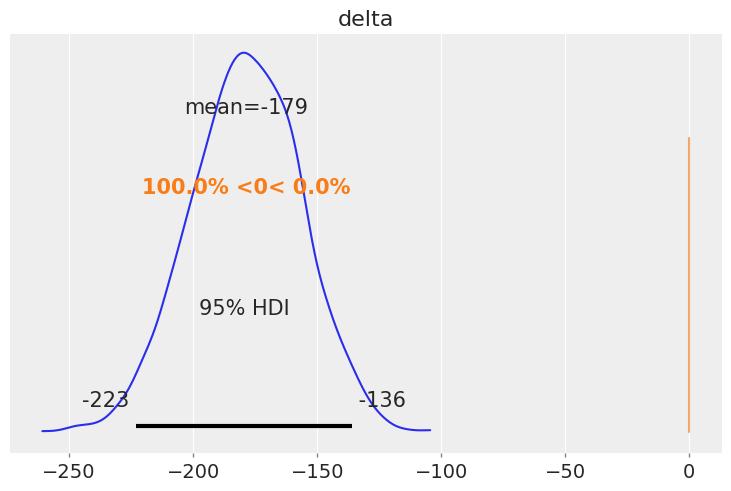

In [9]:
az.plot_posterior(trace_twfe_h_student_t, var_names=['delta'], ref_val=0, hdi_prob=.95);

In [10]:
with twfe_h_student_t:
    pm.compute_log_likelihood(trace_twfe_h_student_t)

Output()

In [11]:
az.waic(trace_twfe_h_student_t)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -11916.23   172.38
p_waic      718.05        -

There has been a warning during the calculation. Please check the results.

## サンプリングの保存

In [ ]:
# az.to_netcdf(trace_twfe, './sample/traces_twfe.nc')
# az.to_netcdf(trace_twfe_h, './sample/traces_twfe_h.nc')
# az.to_netcdf(trace_twfe_student_t, './sample/traces_twfe_student_t.nc')
# az.to_netcdf(trace_twfe_h_student_t, './sample/traces_twfe_h_student_t.nc')

'./sample/traces_twfe_h_student_t.nc'

## サンプリングのインポート

In [4]:
trace_twfe = az.from_netcdf('./sample/traces_twfe.nc')
trace_twfe_h = az.from_netcdf('./sample/traces_twfe_h.nc')
trace_twfe_student_t = az.from_netcdf('./sample/traces_twfe_student_t.nc')
trace_twfe_h_student_t = az.from_netcdf('./sample/traces_twfe_h_student_t.nc')